In [127]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/Users/trongduong/Dropbox/URP project/Code/PQC_Composer')
from utility.quantum_nn import QuantumNeuralNetwork
from utility.data_encoding import FeatureMap
from utility.ansatz_template import AnsatzTemplate
import numpy as np
import fisher_information

import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

np.random.seed(0)

In [133]:
old_fishers = []
new_fishers = []
old_time = []
new_time = []

In [139]:
layer_range = range(1,5)
for layer in layer_range:
    feature_map = FeatureMap('PauliFeatureMap', feature_dim=8, reps=1)

    template = AnsatzTemplate()
    template.construct_simple_template(num_qubits=8, num_layers=layer)

    model = QuantumNeuralNetwork(feature_map, template, platform='Qiskit')
    #template.visualize()

    #print(model.num_qubits, model.input_dim, model.param_dim)
    
    num_inputs = 1
    num_params = 1
    param_dim = (2*model.num_qubits)*(layer+1)
    thetamin = 0
    thetamax = 2*np.pi
    input_dim = 8

    rep_range = np.tile(np.array([num_inputs]), num_params)
    params = np.random.uniform(thetamin, thetamax, size=(num_params, param_dim))
    grid_params = np.repeat(params, repeats=rep_range, axis=0)
    inputs = np.random.normal(0, 1, size=(num_inputs, input_dim))
    grid_inputs = np.tile(inputs, (num_params, 1))
    
    start_time = time.time()
    output_fishers = model.get_fishers(grid_inputs, grid_params)
    
    new_fishers.append(output_fishers[0])
    new_time.append(time.time() - start_time)
    
    #######
    start_time = time.time()
    
    input_ = inputs[0]
    input_dict = compose_param_dict(model.feature_map_circ.parameters, input_)
    param = params[0]

    qc_whole = model.circuit.bind_parameters(input_dict)
    
    # Wrap the quantum circuit into a CircuitStateFn
    state = CircuitStateFn(primitive=qc_whole, coeff=1.)

    # Convert the state and the parameters into the operator object that represents the QFI
    qfi = QFI(qfi_method='lin_comb_full').convert(operator=state, params=list(qc_whole.parameters))
    # Define the values for which the QFI is to be computed
    values_dict = compose_param_dict(qc_whole.parameters, param)   
    
    # Assign the parameters and evaluate the QFI
    qfi_result = qfi.assign_parameters(values_dict).eval()
    
    old_fishers.append(np.real(qfi_result))
    old_time.append(time.time() - start_time)
    
    print(layer)

1
2
3
4


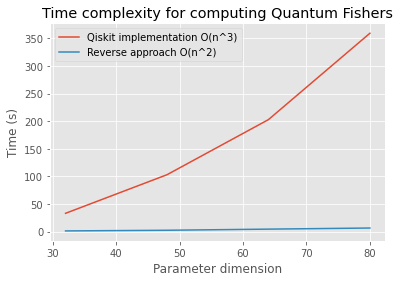

In [153]:
param_range = [(2*model.num_qubits)*(layer+1) for layer in layer_range]
plt.plot(param_range, old_time, label='Qiskit implementation O(n^3)')
plt.plot(param_range, new_time, label='Reverse approach O(n^2)')
plt.xlabel('Parameter dimension')
plt.ylabel('Time (s)')
plt.title('Time complexity for computing Quantum Fishers')
plt.legend()
plt.show()

In [154]:
old_fishers

[array([[ 1.00000000e+00,  2.19000000e-16,  1.53000000e-16, ...,
         -5.02580875e-05,  4.22723493e-02,  1.84522627e-02],
        [ 2.19000000e-16,  1.00000000e+00, -1.91000000e-16, ...,
          1.67023114e-02, -8.77199081e-03,  4.20083225e-02],
        [ 1.53000000e-16, -1.91000000e-16,  1.00000000e+00, ...,
          7.98924795e-02,  3.00151554e-02,  6.88103117e-02],
        ...,
        [-5.02580875e-05,  1.67023114e-02,  7.98924795e-02, ...,
          9.99990778e-01, -5.70874953e-02, -7.95572656e-02],
        [ 4.22723493e-02, -8.77199081e-03,  3.00151554e-02, ...,
         -5.70874953e-02,  9.94210520e-01,  3.16791987e-02],
        [ 1.84522627e-02,  4.20083225e-02,  6.88103117e-02, ...,
         -7.95572656e-02,  3.16791987e-02,  9.93093415e-01]]),
 array([[ 1.00000000e+00,  1.73000000e-16, -1.58000000e-16, ...,
          1.70429037e-02, -2.19185452e-02, -3.44248554e-02],
        [ 1.73000000e-16,  1.00000000e+00,  1.49000000e-16, ...,
          7.09801810e-03,  1.03028686e

In [161]:
new_fishers

[array([[ 1.00000000e+00, -1.82145965e-16, -1.21430643e-16, ...,
         -5.02580875e-05,  4.22723493e-02,  1.84522627e-02],
        [-1.82145965e-16,  1.00000000e+00, -1.70002901e-16, ...,
          1.67023114e-02, -8.77199081e-03,  4.20083225e-02],
        [-1.21430643e-16, -1.70002901e-16,  1.00000000e+00, ...,
          7.98924795e-02,  3.00151554e-02,  6.88103117e-02],
        ...,
        [-5.02580875e-05,  1.67023114e-02,  7.98924795e-02, ...,
          9.99990778e-01, -5.70874953e-02, -7.95572656e-02],
        [ 4.22723493e-02, -8.77199081e-03,  3.00151554e-02, ...,
         -5.70874953e-02,  9.94210520e-01,  3.16791987e-02],
        [ 1.84522627e-02,  4.20083225e-02,  6.88103117e-02, ...,
         -7.95572656e-02,  3.16791987e-02,  9.93093415e-01]]),
 array([[ 1.00000000e+00, -7.28583860e-17, -3.29597460e-17, ...,
          1.70429037e-02, -2.19185452e-02, -3.44248554e-02],
        [-7.28583860e-17,  1.00000000e+00,  1.04083409e-17, ...,
          7.09801810e-03,  1.03028686e

In [162]:
input_dict

{ParameterVectorElement(x[0]): 1.5293307577959387,
 ParameterVectorElement(x[1]): 0.590290655639251,
 ParameterVectorElement(x[2]): -0.7712023341558862,
 ParameterVectorElement(x[3]): -1.139147107879594,
 ParameterVectorElement(x[4]): 1.0638494004116155,
 ParameterVectorElement(x[5]): 0.5031406645698926,
 ParameterVectorElement(x[6]): -1.0376061728473933,
 ParameterVectorElement(x[7]): -0.3567759823352701}

In [163]:
values_dict

{ParameterVectorElement(θ[0]): 6.152014167699496,
 ParameterVectorElement(θ[1]): 1.8466017763938687,
 ParameterVectorElement(θ[2]): 0.6806077371794327,
 ParameterVectorElement(θ[3]): 1.8383839560725388,
 ParameterVectorElement(θ[4]): 0.1755985450265292,
 ParameterVectorElement(θ[5]): 5.729314674942844,
 ParameterVectorElement(θ[6]): 2.9263133150764395,
 ParameterVectorElement(θ[7]): 2.802366717591828,
 ParameterVectorElement(θ[8]): 4.48237289451837,
 ParameterVectorElement(θ[9]): 5.2842521470575665,
 ParameterVectorElement(θ[10]): 5.154119254631957,
 ParameterVectorElement(θ[11]): 4.580234231993499,
 ParameterVectorElement(θ[12]): 3.686149770753091,
 ParameterVectorElement(θ[13]): 1.247425758012522,
 ParameterVectorElement(θ[14]): 3.1606285332804327,
 ParameterVectorElement(θ[15]): 3.364468663529455,
 ParameterVectorElement(θ[16]): 1.5283366192845356,
 ParameterVectorElement(θ[17]): 5.492722410621824,
 ParameterVectorElement(θ[18]): 3.981167470344203,
 ParameterVectorElement(θ[19]): 4.

In [86]:
feature_map = FeatureMap('PauliFeatureMap', feature_dim=8, reps=1)

template = AnsatzTemplate()
template.construct_simple_template(num_qubits=8, num_layers=1)

model = QuantumNeuralNetwork(feature_map, template, platform='Qiskit')
template.visualize()

print(model.num_qubits, model.input_dim, model.param_dim)

     ┌───┐┌──────────┐ ┌──────────┐     ┌───────────┐┌───────────┐             »
q_0: ┤ H ├┤ RX(θ[0]) ├─┤ RY(θ[8]) ├──■──┤ RX(θ[16]) ├┤ RY(θ[24]) ├─────────────»
     ├───┤├──────────┤ ├──────────┤┌─┴─┐└───────────┘├───────────┤┌───────────┐»
q_1: ┤ H ├┤ RX(θ[1]) ├─┤ RY(θ[9]) ├┤ X ├──────■──────┤ RX(θ[17]) ├┤ RY(θ[25]) ├»
     ├───┤├──────────┤┌┴──────────┤└───┘    ┌─┴─┐    └───────────┘├───────────┤»
q_2: ┤ H ├┤ RX(θ[2]) ├┤ RY(θ[10]) ├─────────┤ X ├──────────■──────┤ RX(θ[18]) ├»
     ├───┤├──────────┤├───────────┤         └───┘        ┌─┴─┐    └───────────┘»
q_3: ┤ H ├┤ RX(θ[3]) ├┤ RY(θ[11]) ├──────────────────────┤ X ├──────────■──────»
     ├───┤├──────────┤├───────────┤                      └───┘        ┌─┴─┐    »
q_4: ┤ H ├┤ RX(θ[4]) ├┤ RY(θ[12]) ├───────────────────────────────────┤ X ├────»
     ├───┤├──────────┤├───────────┤                                   └───┘    »
q_5: ┤ H ├┤ RX(θ[5]) ├┤ RY(θ[13]) ├────────────────────────────────────────────»
     ├───┤├──────────┤├─────

In [87]:
num_inputs = 1
num_params = 1
param_dim = 32
thetamin = 0
thetamax = 2*np.pi
input_dim = 8

rep_range = np.tile(np.array([num_inputs]), num_params)
params = np.random.uniform(thetamin, thetamax, size=(num_params, param_dim))
grid_params = np.repeat(params, repeats=rep_range, axis=0)
inputs = np.random.normal(0, 1, size=(num_inputs, input_dim))
grid_inputs = np.tile(inputs, (num_params, 1))

In [88]:
start_time = time.time()
output_fishers = model.get_fishers(grid_inputs, grid_params)
print(output_fishers.shape)
print(output_fishers)
print("--- %s seconds ---" % (time.time() - start_time))

(1, 32, 32)
[[[ 1.00000000e+00 -4.85722573e-17 -8.32667268e-17 ...  8.90935798e-03
    1.77553829e-02 -4.50603914e-03]
  [-4.85722573e-17  1.00000000e+00 -4.85722573e-17 ...  3.44239557e-02
   -1.76481929e-02  7.84976127e-03]
  [-8.32667268e-17 -4.85722573e-17  1.00000000e+00 ...  9.38642553e-03
    2.04483182e-02  6.06413000e-02]
  ...
  [ 8.90935798e-03  3.44239557e-02  9.38642553e-03 ...  9.99677013e-01
   -9.70727211e-03 -4.91344758e-02]
  [ 1.77553829e-02 -1.76481929e-02  2.04483182e-02 ... -9.70727211e-03
    9.91638403e-01  3.69254092e-02]
  [-4.50603914e-03  7.84976127e-03  6.06413000e-02 ... -4.91344758e-02
    3.69254092e-02  9.99427590e-01]]]
--- 1.3267261981964111 seconds ---


In [95]:
test_a = output_fishers[0]
test_a.diagonal()

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999999, 0.99999994,
       0.99999995, 0.9873237 , 0.99999883, 0.99977097, 0.99998905,
       0.99999817, 0.9997019 , 0.99408481, 0.99996525, 0.99987041,
       0.99976314, 0.99977146, 0.99792319, 0.99999858, 0.92058415,
       0.99921954, 0.97939969, 0.99749029, 0.99999759, 0.99967701,
       0.9916384 , 0.99942759])

In [91]:
start = time.time()
wires = 8
n_layers = 1
param_dim = n_layers * wires * 4
#param = np.random.uniform(0, 2 * np.pi, param_dim)
param = params[0]
fisher_info = fisher_information.compute_fisher_matrix(fisher_information.PQC_function, wires, param, n_layers)
print("--- %s seconds ---" % (time.time() - start_time))

--- 70.99495029449463 seconds ---


In [92]:
fisher_info.diagonal()

array([-0.00000000e+00,  1.00000000e+00, -0.00000000e+00,  1.00000000e+00,
        1.11022302e-16,  1.00000000e+00,  1.11022302e-16,  1.00000000e+00,
        2.22044605e-16,  1.00000000e+00,  1.11022302e-16,  1.00000000e+00,
       -0.00000000e+00,  1.00000000e+00, -0.00000000e+00,  1.00000000e+00,
        9.57104375e-01,  9.77010150e-01,  9.19151588e-01,  1.00000000e+00,
        9.57712659e-01,  1.00000000e+00,  9.99334217e-01,  1.00000000e+00,
        9.99248307e-01,  1.00000000e+00,  9.49141752e-01,  1.00000000e+00,
        2.28129772e-01,  1.00000000e+00,  2.07708492e-01,  1.00000000e+00])

In [52]:
#Operator Imports
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian

#Circuit imports
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import EfficientSU2

In [106]:
def compose_param_dict(param_var, param):
    circ_param_dict = {}
    for i, p in enumerate(param_var):
        circ_param_dict[p] = param[i]
    return circ_param_dict

In [116]:
input_ = inputs[0]
input_dict = compose_param_dict(model.feature_map_circ.parameters, input_)

qc_whole = model.circuit.bind_parameters(input_dict)

In [118]:
# Wrap the quantum circuit into a CircuitStateFn
#qc = template.PQC
state = CircuitStateFn(primitive=qc_whole, coeff=1.)

# Convert the state and the parameters into the operator object that represents the QFI
qfi = QFI(qfi_method='lin_comb_full').convert(operator=state, params=list(qc_whole.parameters))
# Define the values for which the QFI is to be computed
#values_dict = {a: np.pi / 4, b: 0.1}
values_dict = compose_param_dict(qc_whole.parameters, param)


In [119]:
start_time = time.time()

# Assign the parameters and evaluate the QFI
qfi_result = qfi.assign_parameters(values_dict).eval()
qfi_result = np.real(qfi_result)

print("--- %s seconds ---" % (time.time() - start_time))
print(qfi_result)

--- 38.34926176071167 seconds ---
[[ 1.00000000e+00  3.26000000e-16  2.43000000e-16 ...  8.90935798e-03
   1.77553829e-02 -4.50603914e-03]
 [ 3.26000000e-16  1.00000000e+00 -1.04000000e-16 ...  3.44239557e-02
  -1.76481929e-02  7.84976127e-03]
 [ 2.43000000e-16 -1.04000000e-16  1.00000000e+00 ...  9.38642553e-03
   2.04483182e-02  6.06413000e-02]
 ...
 [ 8.90935798e-03  3.44239557e-02  9.38642553e-03 ...  9.99677013e-01
  -9.70727211e-03 -4.91344758e-02]
 [ 1.77553829e-02 -1.76481929e-02  2.04483182e-02 ... -9.70727211e-03
   9.91638403e-01  3.69254092e-02]
 [-4.50603914e-03  7.84976127e-03  6.06413000e-02 ... -4.91344758e-02
   3.69254092e-02  9.99427590e-01]]


In [120]:
qfi_result.diagonal()

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999999, 0.99999994,
       0.99999995, 0.9873237 , 0.99999883, 0.99977097, 0.99998905,
       0.99999817, 0.9997019 , 0.99408481, 0.99996525, 0.99987041,
       0.99976314, 0.99977146, 0.99792319, 0.99999858, 0.92058415,
       0.99921954, 0.97939969, 0.99749029, 0.99999759, 0.99967701,
       0.9916384 , 0.99942759])

In [122]:
start_time = time.time()

#Convert the state and the parameters into the operator object that represents the QFI
# and set the approximation to 'block_diagonal'
qfi2 = QFI('overlap_block_diag').convert(operator=state, params=list(qc_whole.parameters))

# Assign the parameters and evaluate the QFI
qfi_result2 = qfi2.assign_parameters(values_dict).eval()
print('Block-diagonal QFI \n', np.real(np.array(qfi_result2)))

print("--- %s seconds ---" % (time.time() - start_time))




start_time = time.time()

# Convert the state and the parameters into the operator object that represents the QFI
# and set the approximation to 'diagonal'
qfi3 = QFI('overlap_diag').convert(operator=state, params=list(qc_whole.parameters))

# Assign the parameters and evaluate the QFI
qfi_result3 = qfi3.assign_parameters(values_dict).eval()
print('Diagonal QFI \n', np.real(np.array(qfi_result3)))

print("--- %s seconds ---" % (time.time() - start_time))

Block-diagonal QFI 
 [[ 0.99908829 -0.06965841 -0.15700288 ...  0.          0.
   0.        ]
 [-0.06965841  0.99897343 -0.03584988 ...  0.          0.
   0.        ]
 [-0.15700288 -0.03584988  0.92013638 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.99999139  0.06200057
  -0.13943042]
 [ 0.          0.          0.         ...  0.06200057  0.99819223
  -0.33614765]
 [ 0.          0.          0.         ... -0.13943042 -0.33614765
   0.99593789]]
--- 8.530728101730347 seconds ---
Diagonal QFI 
 [[0.99908829 0.         0.         ... 0.         0.         0.        ]
 [0.         0.99897343 0.         ... 0.         0.         0.        ]
 [0.         0.         0.92013638 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99999139 0.         0.        ]
 [0.         0.         0.         ... 0.         0.99819223 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99593789]]
--- 0.879676103591

In [123]:
print(qfi_result2.diagonal())
print(qfi_result3.diagonal())

[0.99908829 0.99897343 0.92013638 0.99993403 0.99971921 1.
 1.         1.         0.99910379 0.99999705 0.99617009 0.99356215
 0.97155899 0.99999778 0.99999995 0.99999999 0.99883819 0.99998012
 0.91751847 0.99950025 0.98843788 0.99996222 1.         1.
 0.99394884 0.99999684 0.99755879 0.97929452 0.98039256 0.99999139
 0.99819223 0.99593789]
[0.99908829 0.99897343 0.92013638 0.99993403 0.99971921 1.
 1.         1.         0.99910379 0.99999705 0.99617009 0.99356215
 0.97155899 0.99999778 0.99999995 0.99999999 0.99883819 0.99998012
 0.91751847 0.99950025 0.98843788 0.99996222 1.         1.
 0.99394884 0.99999684 0.99755879 0.97929452 0.98039256 0.99999139
 0.99819223 0.99593789]
